In [1]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

"""
The returned `history` object holds a record of the loss values and metric values
during training:
"""

history.history

"""
We evaluate the model on the test data via `evaluate()`:
"""

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

"""
Now, let's review each piece of this workflow in detail.
"""

"""
## The `compile()` method: specifying a loss, metrics, and an optimizer

To train a model with `fit()`, you need to specify a loss function, an optimizer, and
optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

"""
The `metrics` argument should be a list -- your model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for
each output, and you can modulate the contribution of each output to the total loss of
the model. You will find more details about this in the **Passing data to multi-input,
multi-output models** section.

Note that if you're satisfied with the default settings, in many cases the optimizer,
loss, and metrics can be specified via string identifiers as a shortcut:
"""

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

"""
For later reuse, let's put our model definition and compile step in functions; we will
call them several times across different examples in this guide.
"""


def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


"""
### Many built-in optimizers, losses, and metrics are available

In general, you won't have to create your own losses, metrics, or optimizers
from scratch, because what you need is likely to be already part of the Keras API:

Optimizers:

- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:

- `AUC()`
- `Precision()`
- `Recall()`
- etc.
"""

"""
### Custom losses

If you need to create a custom loss, Keras provides two ways to do so.

The first method involves creating a function that accepts inputs `y_true` and
`y_pred`. The following example shows a loss function that computes the mean squared
error between the real data and the predictions:
"""


def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

"""
If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you
can subclass the `tf.keras.losses.Loss` class and implement the following two methods:

- `__init__(self)`: accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)`: use the targets (y_true) and the model predictions
(y_pred) to compute the model's loss

Let's say you want to use mean squared error, but with an added term that
will de-incentivize  prediction values far from 0.5 (we assume that the categorical
targets are one-hot encoded and take values between 0 and 1). This
creates an incentive for the model not to be too confident, which may help
reduce overfitting (we won't know if it works until we try!).

Here's how you would do it:
"""


class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

"""
### Custom metrics

If you need a metric that isn't part of the API, you can easily create custom metrics
by subclassing the `tf.keras.metrics.Metric` class. You will need to implement 4
methods:

- `__init__(self)`, in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets
y_true and the model predictions y_pred to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_state(self)`, which reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and
`result()`, respectively) because in some cases, the results computation might be very
expensive and would only be done periodically.

Here's a simple example showing how to implement a `CategoricalTruePositives` metric
that counts how many samples were correctly classified as belonging to a given class:
"""


class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

"""
### Handling losses and metrics that don't fit the standard signature

The overwhelming majority of losses and metrics can be computed from `y_true` and
`y_pred`, where `y_pred` is an output of your model -- but not all of them. For
instance, a regularization loss may only require the activation of a layer (there are
no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the call method of
a custom layer. Losses added in this way get added to the "main" loss during training
(the one passed to `compile()`). Here's a simple example that adds activity
regularization (note that activity regularization is built-in in all Keras layers --
this layer is just for the sake of providing a concrete example):
"""


class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

"""
You can do the same for logging metric values, using `add_metric()`:
"""


class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

"""
In the [Functional API](/guides/functional_api/),
you can also call `model.add_loss(loss_tensor)`,
or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:
"""

inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

"""
Note that when you pass losses via `add_loss()`, it becomes possible to call
`compile()` without a loss function, since the model already has a loss to minimize.

Consider the following `LogisticEndpoint` layer: it takes as inputs
targets & logits, and it tracks a crossentropy loss via `add_loss()`. It also
tracks classification accuracy via `add_metric()`.
"""


class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


"""
You can use it in a model with two inputs (input data & targets), compiled without a
`loss` argument, like this:
"""

import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

"""
For more information about training multi-input models, see the section **Passing data
to multi-input, multi-output models**.
"""

"""
### Automatically setting apart a validation holdout set

In the first end-to-end example you saw, we used the `validation_data` argument to pass
a tuple of NumPy arrays `(x_val, y_val)` to the model for evaluating a validation loss
and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically
reserve part of your training data for validation. The argument value represents the
fraction of the data to be reserved for validation, so it should be set to a number
higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of
the data for validation", and `validation_split=0.6` means "use 60% of the data for
validation".

The way the validation is computed is by taking the last x% samples of the arrays
received by the `fit()` call, before any shuffling.

Note that you can only use `validation_split` when training with NumPy data.
"""

model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

"""
## Training & evaluation from tf.data Datasets

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers,
and you've seen how to use the `validation_data` and `validation_split` arguments in
`fit()`, when your data is passed as NumPy arrays.

Let's now take a look at the case where your data comes in the form of a
`tf.data.Dataset` object.

The `tf.data` API is a set of utilities in TensorFlow 2.0 for loading and preprocessing
data in a way that's fast and scalable.

For a complete guide about creating `Datasets`, see the
[tf.data documentation](https://www.tensorflow.org/guide/data).

You can pass a `Dataset` instance directly to the methods `fit()`, `evaluate()`, and
`predict()`:
"""

model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

"""
Note that the Dataset is reset at the end of each epoch, so it can be reused of the
next epoch.

If you want to run training only on a specific number of batches from this Dataset, you
can pass the `steps_per_epoch` argument, which specifies how many training steps the
model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep
drawing the next batches. The dataset will eventually run out of data (unless it is an
infinitely-looping dataset).
"""

model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

"""
### Using a validation dataset

You can pass a `Dataset` instance as the `validation_data` argument in `fit()`:
"""

model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

"""
At the end of each epoch, the model will iterate over the validation dataset and
compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this dataset,
you can pass the `validation_steps` argument, which specifies how many validation
steps the model should run with the validation dataset before interrupting validation
and moving on to the next epoch:
"""

model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

"""
Note that the validation dataset will be reset after each use (so that you will always
be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is
not supported when training from `Dataset` objects, since this feature requires the
ability to index the samples of the datasets, which is not possible in general with
the `Dataset` API.
"""

"""
## Other input formats supported

Besides NumPy arrays, eager tensors, and TensorFlow `Datasets`, it's possible to train
a Keras model using Pandas dataframes, or from Python generators that yield batches of
data & labels.

In particular, the `keras.utils.Sequence` class offers a simple interface to build
Python data generators that are multiprocessing-aware and can be shuffled.

In general, we recommend that you use:

- NumPy input data if your data is small and fits in memory
- `Dataset` objects if you have large datasets and you need to do distributed training
- `Sequence` objects if you have large datasets and you need to do a lot of custom
Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries
for data loading or preprocessing).


## Using a `keras.utils.Sequence` object as input

`keras.utils.Sequence` is a utility that you can subclass to obtain a Python generator with
two important properties:

- It works well with multiprocessing.
- It can be shuffled (e.g. when passing `shuffle=True` in `fit()`).

A `Sequence` must implement two methods:

- `__getitem__`
- `__len__`

The method `__getitem__` should return a complete batch.
If you want to modify your dataset between epochs, you may implement `on_epoch_end`.

Here's a quick example:

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

"""

"""
## Using sample weighting and class weighting

With the default settings the weight of a sample is decided by its frequency
in the dataset. There are two methods to weight the data, independent of
sample frequency:

* Class weights
* Sample weights
"""

"""
### Class weights

This is set by passing a dictionary to the `class_weight` argument to
`Model.fit()`. This dictionary maps class indices to the weight that should
be used for samples belonging to this class.

This can be used to balance classes without resampling, or to train a
model that gives more importance to a particular class.

For instance, if class "0" is half as represented as class "1" in your data,
you could use `Model.fit(..., class_weight={0: 1., 1: 0.5})`.
"""

"""
Here's a NumPy example where we use class weights or sample weights to
give more importance to the correct classification of class #5 (which
is the digit "5" in the MNIST dataset).
"""

import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

"""
### Sample weights

For fine grained control, or if you are not building a classifier,
you can use "sample weights".

- When training from NumPy data: Pass the `sample_weight`
  argument to `Model.fit()`.
- When training from `tf.data` or any other sort of iterator:
  Yield `(input_batch, label_batch, sample_weight_batch)` tuples.

A "sample weights" array is an array of numbers that specify how much weight
each sample in a batch should have in computing the total loss. It is commonly
used in imbalanced classification problems (the idea being to give more weight
to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a *mask* for
the loss function (entirely discarding the contribution of certain samples to
the total loss).
"""

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

"""
Here's a matching `Dataset` example:
"""

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

"""
## Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of
shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what
about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's
`(height, width, channels)`) and a time series input of shape `(None, 10)` (that's
`(timesteps, features)`). Our model will have two outputs computed from the
combination of these inputs: a "score" (of shape `(1,)`) and a probability
distribution over five classes (of shape `(5,)`).
"""

image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

"""
Let's plot this model, so you can clearly see what we're doing here (note that the
shapes shown in the plot are batch shapes, rather than per-sample shapes).
"""

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

"""
At compilation time, we can specify different losses to different outputs, by passing
the loss functions as a list:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

"""
If we only passed a single loss function to the model, the same loss function would be
applied to every output (which is not appropriate here).

Likewise for metrics:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

"""
Since we gave names to our output layers, we could also specify per-output losses and
metrics via a dict:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

"""
We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for
instance, one might wish to privilege the "score" loss in our example, by giving to 2x
the importance of the class loss), using the `loss_weights` argument:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

"""
You could also choose not to compute a loss for certain outputs, if these outputs are
meant for prediction but not for training:
"""

# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

"""
Passing data to a multi-input or multi-output model in `fit()` works in a similar way as
specifying a loss function in compile: you can pass **lists of NumPy arrays** (with
1:1 mapping to the outputs that received a loss function) or **dicts mapping output
names to NumPy arrays**.
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

"""
Here's the `Dataset` use case: similarly as what we did for NumPy arrays, the `Dataset`
should return a tuple of dicts.
"""

train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

"""
## Using callbacks

Callbacks in Keras are objects that are called at different points during training (at
the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They
can be used to implement certain behaviors, such as:

- Doing validation at different points during training (beyond the built-in per-epoch
validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy
threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain
performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to `fit()`:
"""

model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

"""
### Many built-in callbacks are available

There are many built-in callbacks already available in Keras, such as:

- `ModelCheckpoint`: Periodically save the model.
- `EarlyStopping`: Stop training when training is no longer improving the validation
metrics.
- `TensorBoard`: periodically write model logs that can be visualized in
[TensorBoard](https://www.tensorflow.org/tensorboard) (more details in the section
"Visualization").
- `CSVLogger`: streams loss and metrics data to a CSV file.
- etc.

See the [callbacks documentation](/api/callbacks/) for the complete list.

### Writing your own callback

You can create a custom callback by extending the base class
`keras.callbacks.Callback`. A callback has access to its associated model through the
class property `self.model`.

Make sure to read the
[complete guide to writing custom callbacks](/guides/writing_your_own_callbacks/).

Here's a simple example saving a list of per-batch loss values during training:
"""


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


"""
## Checkpointing models

When you're training model on relatively large datasets, it's crucial to save
checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the `ModelCheckpoint` callback:
"""

model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

"""
The `ModelCheckpoint` callback can be used to implement fault-tolerance:
the ability to restart training from the last saved state of the model in case training
gets randomly interrupted. Here's a basic example:
"""

import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

"""
You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see the
[guide to saving and serializing Models](/guides/serialization_and_saving/).
"""

"""
## Using learning rate schedules

A common pattern when training deep learning models is to gradually reduce the learning
as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the
current epoch or the current batch index), or dynamic (responding to the current
behavior of the model, in particular the validation loss).

### Passing a schedule to an optimizer

You can easily use a static learning rate decay schedule by passing a schedule object
as the `learning_rate` argument in your optimizer:
"""

initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

"""
Several built-in schedules are available: `ExponentialDecay`, `PiecewiseConstantDecay`,
`PolynomialDecay`, and `InverseTimeDecay`.

### Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the
validation loss is no longer improving) cannot be achieved with these schedule objects,
since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can
thus achieve this pattern by using a callback that modifies the current learning rate
on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.
"""

"""
## Visualizing loss and metrics during training

The best way to keep an eye on your model during training is to use
[TensorBoard](https://www.tensorflow.org/tensorboard) -- a browser-based application
that you can run locally that provides you with:

- Live plots of the loss and metrics for training and evaluation
- (optionally) Visualizations of the histograms of your layer activations
- (optionally) 3D visualizations of the embedding spaces learned by your `Embedding`
layers

If you have installed TensorFlow with pip, you should be able to launch TensorBoard
from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```
"""

"""
### Using the TensorBoard callback

The easiest way to use TensorBoard with a Keras model and the `fit()` method is the
`TensorBoard` callback.

In the simplest case, just specify where you want the callback to write logs, and
you're good to go:
"""

keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

"""
For more information, see the
[documentation for the `TensorBoard` callback](https://keras.io/api/callbacks/tensorboard/).
"""

Tensorflow version:  2.8.0
Num GPUs Available:  0
Fit model on training data
Epoch 1/2
782/782 [==============================] - 2s 2ms/step - loss: 0.3386 - sparse_categorical_accuracy: 0.9016 - val_loss: 0.1685 - val_sparse_categorical_accuracy: 0.9529
Epoch 2/2
782/782 [==============================] - 1s 2ms/step - loss: 0.1567 - sparse_categorical_accuracy: 0.9525 - val_loss: 0.1357 - val_sparse_categorical_accuracy: 0.9602
Evaluate on test data
79/79 [==============================] - 0s 1ms/step - loss: 0.1398 - sparse_categorical_accuracy: 0.9583
test loss, test acc: [0.13977232575416565, 0.958299994468689]
Generate predictions for 3 samples
predictions shape: (3, 10)
782/782 [==============================] - 2s 1ms/step - loss: 0.0388
Epoch 1/3
782/782 [==============================] - 2s 2ms/step - loss: 0.3350 - categorical_true_positives: 45171.0000
Epoch 2/3
782/782 [==============================] - 1s 2ms/step - loss: 0.1544 - categorical_true_positives: 47661.0000
E

'\nFor more information, see the\n[documentation for the `TensorBoard` callback](https://keras.io/api/callbacks/tensorboard/).\n'

Torch version:  1.11.0+cu102
GPU available?  True
Files already downloaded and verified
Files already downloaded and verified


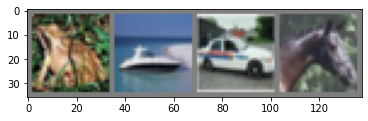

frog  ship  car   horse
[1,  2000] loss: 2.244
[1,  4000] loss: 1.898
[1,  6000] loss: 1.727
[1,  8000] loss: 1.628
[1, 10000] loss: 1.562
[1, 12000] loss: 1.498
[2,  2000] loss: 1.425
[2,  4000] loss: 1.420
[2,  6000] loss: 1.380
[2,  8000] loss: 1.328
[2, 10000] loss: 1.321
[2, 12000] loss: 1.309
Finished Training


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

print("Torch version: ", torch.__version__)
print("GPU available? ", torch.cuda.is_available())

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

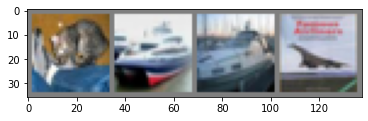

GroundTruth:  cat   ship  ship  plane


In [3]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))